In [2]:
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt
import math

import read_orbits
from solar_system_names import *

Global Constants

In [3]:
# Global constants
AU = 149.6e6 * 1000 # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (2/24.) # 2 hours
MSUN = 1.9885e+30
MEARTH = 5.9724e+24
G = 6.67428e-11/AU**3*MEARTH*DAY**2

# Helper functions

In [4]:
# Based on the tensorflow_graphics package

def log10(x):
    #numerator = tf.log(x)
    #denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    #return numerator / denominator
    return tf.experimental.numpy.log10(x)

def cartesian_to_spherical_coordinates(point_cartesian, eps=None):
    """Function to transform Cartesian coordinates to spherical coordinates.
    This function assumes a right handed coordinate system with `z` pointing up.
    When `x` and `y` are both `0`, the function outputs `0` for `phi`. Note that
    the function is not smooth when `x = y = 0`.
    Note:
      In the following, A1 to An are optional batch dimensions.
    Args:
      point_cartesian: A tensor of shape `[A1, ..., An, 3]`. In the last
        dimension, the data follows the `x`, `y`, `z` order.
      eps: A small `float`, to be added to the denominator. If left as `None`,
        its value is automatically selected using `point_cartesian.dtype`.
      name: A name for this op. Defaults to `cartesian_to_spherical_coordinates`.
    Returns:
      A tensor of shape `[A1, ..., An, 3]`. The last dimensions contains
      (`r`,`theta`,`phi`), where `r` is the sphere radius, `theta` is the polar
      angle and `phi` is the azimuthal angle.
    """
    #with tf.compat.v1.name_scope(name, "cartesian_to_spherical_coordinates",
    #                             [point_cartesian]):
    #  point_cartesian = tf.convert_to_tensor(value=point_cartesian)

    #shape.check_static(
    #    tensor=point_cartesian,
    #    tensor_name="point_cartesian",
    #    has_dim_equals=(-1, 3))

    x, y, z = tf.unstack(point_cartesian, axis=-1)
    radius = tf.norm(tensor=point_cartesian, axis=-1)
    theta = tf.acos(
        tf.clip_by_value(tf.divide(z, radius), -1., 1.))
    phi = tf.atan2(y, x)
    return tf.stack((log10(radius), theta, phi), axis=-1)

def spherical_to_cartesian_coordinates(point_spherical, name=None):
    """Function to transform Cartesian coordinates to spherical coordinates.
    Note:
      In the following, A1 to An are optional batch dimensions.
    Args:
      point_spherical: A tensor of shape `[A1, ..., An, 3]`. The last dimension
        contains r, theta, and phi that respectively correspond to the radius,
        polar angle and azimuthal angle; r must be non-negative.
      name: A name for this op. Defaults to 'spherical_to_cartesian_coordinates'.
    Raises:
      tf.errors.InvalidArgumentError: If r, theta or phi contains out of range
      data.
    Returns:
      A tensor of shape `[A1, ..., An, 3]`, where the last dimension contains the
      cartesian coordinates in x,y,z order.
    """
    #with tf.compat.v1.name_scope(name, "spherical_to_cartesian_coordinates",
    #                           [point_spherical]):
    #point_spherical = tf.convert_to_tensor(value=point_spherical)

    #shape.check_static(
    #    tensor=point_spherical,
    #    tensor_name="point_spherical",
    #    has_dim_equals=(-1, 3))

    logr, theta, phi = tf.unstack(point_spherical, axis=-1)
    r = tf.pow(10., logr)
    #r = asserts.assert_all_above(r, 0)
    tmp = r * tf.sin(theta)
    x = tmp * tf.cos(phi)
    y = tmp * tf.sin(phi)
    z = r * tf.cos(theta)
    return tf.stack((x, y, z), axis=-1)

In [5]:
def force_newton(x, m1, m2):
    return G*m1*m2/np.linalg.norm(x, axis = -1, keepdims=True)**3.*x

def reshape_senders_receivers(senders, receivers, batch_size, nplanets, nedges):
    ''' Reshape receivers and senders to use in graph'''
    x = np.arange(batch_size)
    xx = x.reshape(batch_size,1)
    y = np.ones(nedges)
    z = np.reshape(xx+y-1, batch_size*nedges)*nplanets

    senders = np.concatenate([senders]*batch_size) + z
    receivers = np.concatenate([receivers]*batch_size) + z
    
    return senders, receivers

def build_rotation_matrix(a,b,g):
    A0 = tf.stack([tf.cos(a)*tf.cos(b), tf.sin(a)*tf.cos(b), -tf.sin(b)], 
                  axis=0)
    A1 = tf.stack([tf.cos(a)*tf.sin(b)*tf.sin(g)-tf.sin(a)*tf.cos(g), 
                   tf.sin(a)*tf.sin(b)*tf.sin(g)+tf.cos(a)*tf.cos(g),
                   tf.cos(b)*tf.sin(g)], axis=0)
    A2 = tf.stack([tf.cos(a)*tf.sin(b)*tf.cos(g)+tf.sin(a)*tf.sin(g), 
                   tf.sin(a)*tf.sin(b)*tf.cos(g)-tf.cos(a)*tf.sin(g),
                   tf.cos(b)*tf.cos(g)], axis=0)
    
    return tf.stack((A0, A1, A2), axis=1)

def rotate_data(D, A):
    # I think the maxes should be 2pi, pi, pi, but going for overkill just in case
    alpha = tf.random.uniform([], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    beta = tf.random.uniform([], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    gamma = tf.random.uniform([], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    #print(alpha) #It works! (Different every time)
    R = build_rotation_matrix(alpha,beta,gamma)
    #D = tf.einsum('ij,jk->ik', D,R)
    #A = tf.einsum('ij,jk->ik', A,R)
    D = tf.linalg.matmul(D,R)
    A = tf.linalg.matmul(A,R)
    return D, A

Training variables

In [6]:
# Training variables
patience = 5
d_patience = 0
noise_level = 0.05
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
total_time_traj = 20 #Years
num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_tr = 130000 #An orbit for saturn is 129110 steps
num_time_steps_sr = 500
num_batches = 650
#num_time_steps_val = int(total_time_traj/delta_time) - num_time_steps_tr

Read the data

In [7]:
nplanets = 6 # Number of planets (not counting the sun)
data, masses, names = read_orbits.main(nplanets = nplanets, frame='b', use_moons = True, 
                                       path='/Users/Pablo/Dropbox/data/orbits/2parts/full/')
nplanets = len(data[0])
nedges = nplanets*(nplanets-1)//2
batch_size_tr = num_time_steps_tr//num_batches

# Get the acceleration
A = data[1:,:,3:] - data[:-1,:,3:]
data[:-1, :, 3:] = A/delta_time 
data = data[:-1]

# For debugging, reduce size of validation data. Really speeds things up!
nval = 10000
data = data[:(num_time_steps_tr + nval)]

masses/=MEARTH#/1000000

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

num_time_steps_val = len(data_val)

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

D_tr_np = np.empty([len(data_tr), nedges, 3])
D_val_np = np.empty([len(data_val), nedges, 3])
data_norm = np.empty([len(data_tr), nedges, 3])
F_val = np.empty([len(data_val), nedges, 3])
k=0
names_edges = []
senders, receivers = [], []
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_tr = data_tr[:,j,:3] - data_tr[:,i,:3]
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            D_tr_np[:,k,:] = d_tr#cartesian_to_spherical_coordinates(d_tr)
            D_val_np[:,k,:] = d_val #cartesian_to_spherical_coordinates(d_val)
            F_val[:,k,:] = force_newton(d_val, masses[i], masses[j]) #cartesian_to_spherical_coordinates(d_val)
            names_edges.append(names[j] + ' - ' + names[i])
            #data_norm[:,k,0] = np.log10(masses[i])
            #data_norm[:,k,1] = np.log10(masses[j])
            #data_norm[:,k,2] = np.log10(G)
            k+=1 
            receivers.append(i)
            senders.append(j)

A_tr = data_tr[:,:,3:]
A_val = data_val[:,:,3:]
A_norm =np.std(A_tr) 
#A_norm = 1.

#data_norm = np.concatenate([D_tr_np, data_norm], axis = 2)

A_norm_dim= tf.reduce_mean(tf.norm(A_tr/A_norm, axis = -1, keepdims = False), axis = 0)
A_norm_tr = tf.convert_to_tensor([A_norm_dim]*batch_size_tr, dtype="float32")
A_norm_tr = tf.reshape(A_norm_tr, shape = [batch_size_tr*nplanets, 1])
A_norm_val = tf.convert_to_tensor([A_norm_dim]*num_time_steps_val, dtype="float32")
A_norm_val = tf.reshape(A_norm_val, shape = [num_time_steps_val*nplanets, 1])

D_tr_flat = np.reshape(D_tr_np, [num_time_steps_tr*nedges, 3])
D_val_flat = np.reshape(D_val_np,[1, num_time_steps_val*nedges, 3])
#data_norm_flat = np.reshape(data_norm, [num_time_steps_tr*nedges, 6])

A_tr_flat = np.reshape(A_tr/A_norm, [num_time_steps_tr*nplanets, 3])
A_val_flat = np.reshape(A_val/A_norm, [1, num_time_steps_val*nplanets, 3])

D_tr = tf.convert_to_tensor(D_tr_flat, dtype="float32")
A_tr = tf.convert_to_tensor(A_tr_flat, dtype="float32")
D_tr_batches = tf.split(D_tr,  num_batches)
A_tr_batches = tf.split(A_tr,  num_batches)
#data_norm = tf.convert_to_tensor(data_norm_flat, dtype="float32")

D_val = tf.convert_to_tensor(D_val_flat, dtype="float32")
A_val = tf.convert_to_tensor(A_val_flat, dtype="float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (D_tr_batches, A_tr_batches))#.batch(batch_size_tr)

test_ds = tf.data.Dataset.from_tensor_slices(
    (D_val, A_val))

#D_val = tf.convert_to_tensor(D_val[:,:,:], dtype="float32")
#A_val = tf.convert_to_tensor(A_val/A_norm, dtype="float32")

#D_val_flat = tf.reshape(D_val, shape = [num_time_steps_val*nedges, 3])
#A_val_flat = tf.reshape(A_val/A_norm, shape = [num_time_steps_val*nedges, 3])

masses_tf = tf.convert_to_tensor(masses, dtype="float32")

nodes_tr = np.concatenate([np.log10(masses)]*batch_size_tr)[:,np.newaxis]
nodes_val = np.concatenate([np.log10(masses)]*num_time_steps_val)[:,np.newaxis]
nodes_sr = np.concatenate([np.log10(masses)]*num_time_steps_sr)[:,np.newaxis]

senders_tr, receivers_tr = reshape_senders_receivers(senders, receivers, batch_size_tr, nplanets, nedges)
senders_val, receivers_val = reshape_senders_receivers(senders, receivers, num_time_steps_val, nplanets, nedges)
senders_sr, receivers_sr = reshape_senders_receivers(senders, receivers, num_time_steps_sr, nplanets, nedges)

Reading data in Solar System barycenter reference frame
Reading data for mercury
Reading data for venus
Reading data for earth
Reading data for moon
Reading data for mars
Reading data for jupiter
Reading data for io
Reading data for europa
Reading data for ganymede
Reading data for callisto
Reading data for saturn
Reading data for mimas
Reading data for enceladus
Reading data for tethys
Reading data for dione
Reading data for rhea
Reading data for titan
Reading data for iapetus
Finished reading data
The data array contains 19 bodies.


In [8]:
def mean_weighted_error(y_true, y_pred, norm):
    x = (y_pred - y_true)/tf.norm(y_true, axis = -1, keepdims=True)
    x = tf.norm(x, axis=-1)
    loss = tf.reduce_mean(x)
    #print(y_pred, y_true, loss)
    
    #x = (y_pred - y_true)/norm*tf.reduce_mean(norm)
    #loss = tf.reduce_mean(tf.reduce_sum(x**2, axis = -1))
    #result = tf.cond(tf.math.is_nan(loss), lambda: tf.constant(1e40), lambda: loss)
    return loss
    
class MeanWeightedError(tf.keras.metrics.Metric):
    def __init__(self, name="mean_weighted_error", **kwargs):
        super(MeanWeightedError, self).__init__(name=name, **kwargs)
        self.mwe = self.add_weight(name="mwe", initializer="zeros")

    def update_state(self, y_true, y_pred, norm):
        self.mwe.assign_add(mean_weighted_error(y_true, y_pred, norm))

    def result(self):
        return self.mwe

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.mwe.assign(0.0)


In [9]:
#normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[6,])
#normalizer.adapt(data_norm)

In [25]:
#nplanets, _, ntime = X.shape
loss_tracker = tf.keras.metrics.Mean(name='loss')
#loss_test = tf.keras.metrics.MeanAbsoluteError(name='loss_test')
loss_test = MeanWeightedError(name='loss_test')

class LearnForces(tf.keras.Model):
    def __init__(self):
        super(LearnForces, self).__init__()
        self.opt1 = tf.keras.optimizers.Adam(learning_rate=1e-2)
        self.opt2 = tf.keras.optimizers.Adam(learning_rate=1e-3)
        #self.test_loss_metric = tf.keras.metrics.MeanAbsoluteError(name='test_loss')
        
        logm_init = tf.random_normal_initializer(mean=0.0, stddev=0.1)
        #logm_init = tf.constant_initializer(np.log10(masses[1:]))
        #logG_init = tf.constant_initializer(np.log10(G/A_norm))
        logG_init = tf.random_normal_initializer(mean=0.0, stddev=1.0)
        
        M = tf.constant_initializer([
                         [-2, 0., 0.], 
                         [0., 1., 0.],
                         [0., 0., 1.],
                         [1., 0., 0.], 
                         [1., 0., 0.], 
                         [1., 0., 0.],
                                    ],)
        
        self.logm_planets = tf.Variable(
            initial_value=logm_init(shape=(nplanets-1,), dtype="float32"),
            trainable=True,
        )
        #a = tf.constant([0.], dtype = tf.float32)
        #self.logm = tf.concat([a, self.logm_planets], axis=0)
        
        self.logG = tf.Variable(
            initial_value=logG_init(shape=(1,), dtype="float32"),
            trainable=True,
        )
        
        self.graph_network = gn.blocks.EdgeBlock(
            #edge_model_fn=lambda: snt.Linear(3, with_bias = False, 
            #                                 w_init=M),
            #edge_model_fn=lambda: snt.nets.MLP([32, 32, 3],
            #                                  with_bias = True,
            #                                  activation = tf.keras.activations.tanh),
            edge_model_fn = lambda: snt.Sequential([
                                                  #normalizer,
                                                  tf.keras.layers.Dense(128, input_dim=6, kernel_initializer='normal', activation='relu'),
                                                  tf.keras.layers.Dense(128, activation='relu'),
                                                  tf.keras.layers.Dense(128, activation='relu'),
                                                  #tf.nn.relu,
                                                  snt.Linear(3),
                                                            ]),
            use_edges = True,
            use_receiver_nodes = True,
            use_sender_nodes = True,
            use_globals = True,
        )
                


    def sum_forces(self, graph):
        b1_tr = gn.blocks.ReceivedEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        b2_tr = gn.blocks.SentEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        summed_forces = b1_tr-b2_tr
        return summed_forces
            
    def get_acceleration(self, forces, graph):
        acceleration_tr = tf.divide(forces, tf.pow(10.,graph.nodes))
        return acceleration_tr
        #output_ops_tr = tf.reshape(acceleration_tr, shape=[self.ntime, self.nplanets, 3])
        #return output_ops_tr
        
    def call(self, D, training = False, extract = False):
        #self.ntime = len(g.nodes)//nplanets
        ntime = len(D)//nedges
        if training == True:
            m_noise = tf.random.normal(tf.shape(self.logm_planets), 0, noise_level, tf.float32)
            lm = self.logm_planets*(1+ m_noise)
        else: 
            lm = self.logm_planets
            
        a = tf.constant([np.log10(masses[0])], dtype = tf.float32)
        lm = tf.concat([a, lm], axis=0)
        
        #nodes_g = np.concatenate([np.log10(masses_tf)]*ntime)[:,np.newaxis]
        nodes_g = tf.concat([lm]*ntime, axis = 0)
        nodes_g = tf.expand_dims(nodes_g, 1)
        senders_g, receivers_g = reshape_senders_receivers(senders, receivers, ntime, nplanets, nedges)
        
        # Create graph
        graph_dict = { 
          "nodes": nodes_g,
          "edges": cartesian_to_spherical_coordinates(D), 
          "receivers": receivers_g, 
          "senders": senders_g ,
          "globals": self.logG
           } 
    
        g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])

        g = self.graph_network(g)
        g = g.replace(
            edges = spherical_to_cartesian_coordinates(g.edges))
        f = self.sum_forces(g)
        a = self.get_acceleration(f, g)
        if extract == True: 
            f = tf.reshape(g.edges, shape=[-1, nedges, 3]).numpy()
            a = tf.reshape(a, shape=[-1, nplanets, 3]).numpy()
            return a, f
        else: 
            return a
    
    def train_step(self, data):
        #if isinstance(data, tuple):
        #    data = data[0]
        # Unpack the data
        D, A = data
        
        D_rot, A_rot = rotate_data(D, A)
        #D_rot, A_rot = D, A
        
        D_noise = tf.random.normal(tf.shape(D), 0, noise_level, tf.float32)
        D_rot = D_rot*(1+ D_noise)
                                   
        # Could make a "get_senders_receivers" function, that takes
        # nplanets and returns the arrays. 
        # Will also have to make one that gets the nodes from the 
        # masses it is learning
        # That will make everything more self contained

        # Randomly 3D rotate the data
        
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = self(D_rot, training = True)
            # Compute the loss
            loss = mean_weighted_error(A_rot, predictions, A_norm_tr)
        
        # Compute gradients
        # Trainable variables are the masses and the MLP layers 
        #Trainable_vars = self.trainable_variables+ list(self.graph_network.trainable_variables)
        #gradients = tape.gradient(loss, trainable_vars)
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        # Update weights
        #self.optimizer.apply_gradients(zip(gradients,trainable_vars))


        var_list1 = self.trainable_variables
        var_list2 = list(self.graph_network.trainable_variables)
        gradients = tape.gradient(loss, var_list1 + var_list2)
        grads1 = gradients[:len(var_list1)]
        grads2 = gradients[len(var_list1):]
        #grads1, _ = tf.clip_by_global_norm(grads1, 5.0)
        #grads2, _ = tf.clip_by_global_norm(grads2, 5.0)
        train_op1 = self.opt1.apply_gradients(zip(grads1, var_list1))
        train_op2 = self.opt2.apply_gradients(zip(grads2, var_list2)) 
        train_op = tf.group(train_op1, train_op2)        
        
        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    def test_step(self,data):
        # Unpack the data
        D, A = data
        
        predictions = self(D)

        #self.A_pred = tf.reshape(predictions, shape=[-1, self.nplanets, 3])
        #loss_test = tf.keras.metrics.MeanAbsoluteError(A, predictions)
        #loss_tracker.update_state(loss_test)

        #self.losses.append(tf.keras.losses.MeanAbsoluteError)
        # Updates the metrics tracking the loss
        #self.compiled_loss(A, predictions, regularization_losses=self.losses) 
    
        # Update the metrics.
        #loss_test.update_state(A, predictions)
        loss_test.update_state(A, predictions, A_norm_val)
        
        return {"loss": loss_test.result()}
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, loss_test]



In [26]:
checkpoint_filepath = './saved_models/deep'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            verbose = 1,
                                            patience=50,
                                            #baseline = 0.1,
                                            restore_best_weights=False)
# Restore best weights not working, but found way around using checkpoint

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                save_best_only=True,
                                                 verbose=0)
model = LearnForces()

#model.compile(run_eagerly=True)
model.compile()

In [229]:
# The goal is a validation loss 0.0575

model.fit(train_ds, 
          epochs = 1000, 
          verbose=2,
          #callbacks=[early_stopping], 
          callbacks=[early_stopping, checkpoint], 
          validation_data=test_ds
         )

Epoch 1/1000
650/650 - 40s - loss: 0.2071 - val_loss: 0.1968
Epoch 2/1000
650/650 - 40s - loss: 0.2083 - val_loss: 0.1996
Epoch 3/1000
650/650 - 40s - loss: 0.2084 - val_loss: 0.1957
Epoch 4/1000
650/650 - 40s - loss: 0.2073 - val_loss: 0.2008
Epoch 5/1000
650/650 - 40s - loss: 0.2073 - val_loss: 0.1953
Epoch 6/1000
650/650 - 40s - loss: 0.2077 - val_loss: 0.1943
Epoch 7/1000
650/650 - 40s - loss: 0.2075 - val_loss: 0.1944
Epoch 8/1000
650/650 - 40s - loss: 0.2069 - val_loss: 0.1963
Epoch 9/1000
650/650 - 40s - loss: 0.2080 - val_loss: 0.2013
Epoch 10/1000
650/650 - 40s - loss: 0.2075 - val_loss: 0.1978
Epoch 11/1000
650/650 - 40s - loss: 0.2071 - val_loss: 0.1972
Epoch 12/1000
650/650 - 40s - loss: 0.2074 - val_loss: 0.2029
Epoch 13/1000
650/650 - 40s - loss: 0.2074 - val_loss: 0.1956
Epoch 14/1000
650/650 - 40s - loss: 0.2070 - val_loss: 0.2073
Epoch 15/1000
650/650 - 40s - loss: 0.2068 - val_loss: 0.2063
Epoch 16/1000
650/650 - 40s - loss: 0.2068 - val_loss: 0.1977
Epoch 17/1000
650

In [ ]:
# The goal is a loss 0.0575

In [28]:
#model.load_weights(checkpoint_filepath)

model.evaluate(test_ds)

1/1 [==============================] - 1s 898ms/step - loss: 0.2013


0.20126588642597198

# Evaluate on validation data

In [29]:
ap ,fp = model(D_val_flat[0], extract = True)


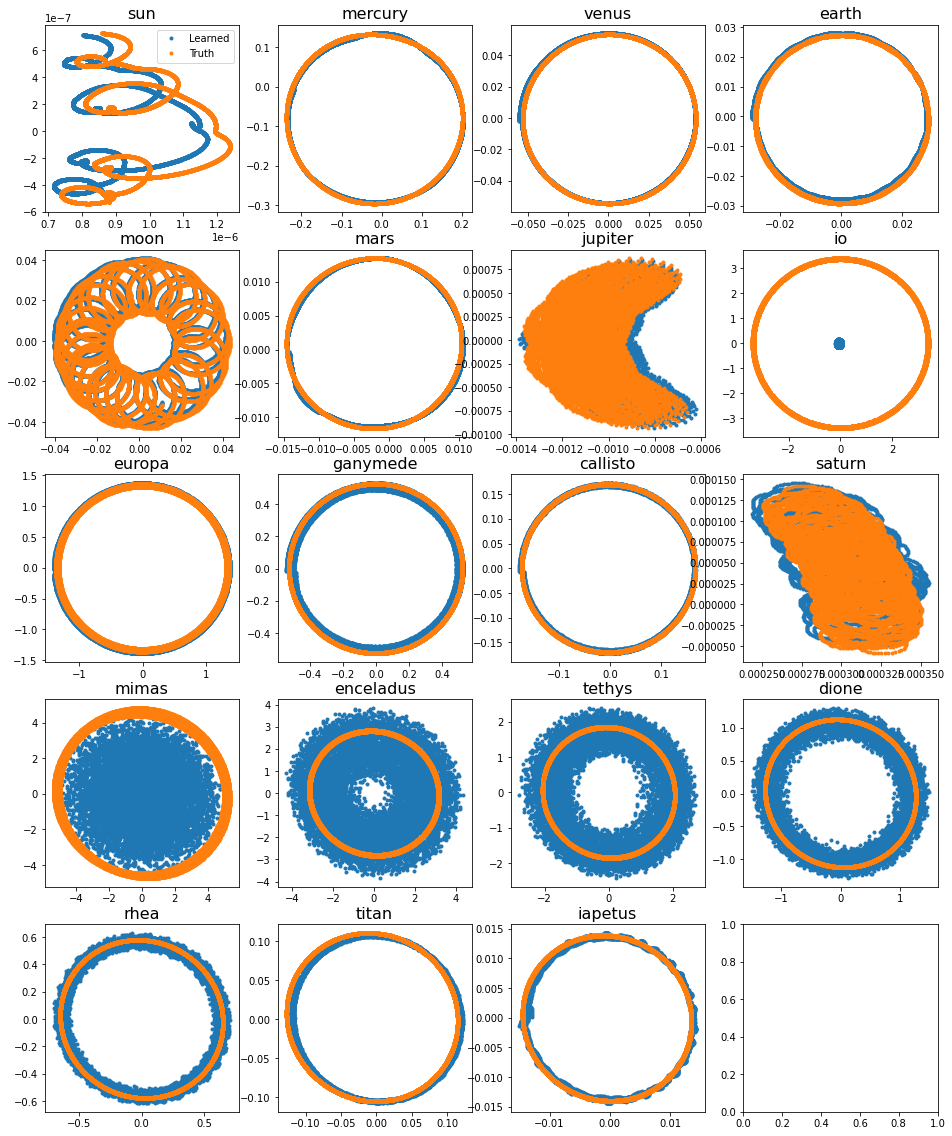

In [30]:
nrows = math.ceil(nplanets/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nplanets):
    ax[i//4, i%4].set_title(names[i], fontsize = 16)
    ax[i//4, i%4].plot(ap[:,i,0], ap[:,i,1], '.', label = 'Learned')
    ax[i//4, i%4].plot(data_val[:,i,3]/A_norm, data_val[:,i,4]/A_norm, '.', label = 'Truth')

ax[0,0].legend()
#plt.savefig('/Users/Pablo/Desktop/full_learnedmasses.png')

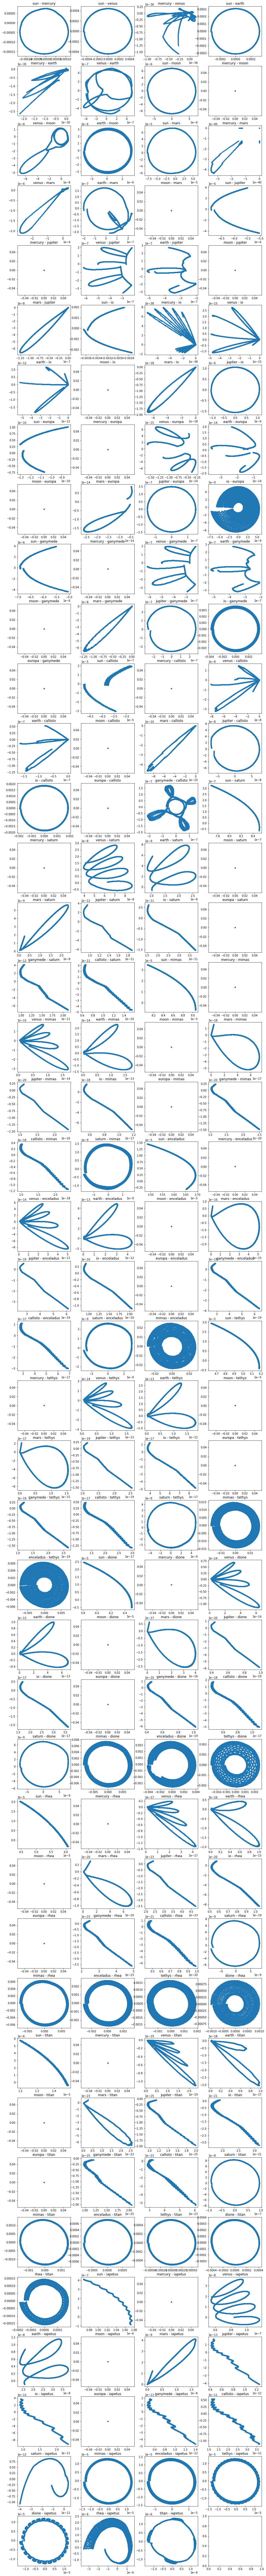

In [32]:
nrows = math.ceil(nedges/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nedges):
    ax[i//4, i%4].set_title(names_edges[i])
    #ax[i//4, i%4].plot(F_val[:,i,0], F_val[:,i,1], '.')
    ax[i//4, i%4].plot(fp[:,i,0]*A_norm, fp[:,i,1]*A_norm, '.')
#plt.savefig('/Users/Pablo/Desktop/forces_learnedmasses.png')

In [225]:
abs(model.logm_planets.numpy() - np.log10(masses[1:]))/abs(np.log10(masses[1:]))

/Users/Pablo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.01641808, 0.23060025,        inf, 0.14277169, 0.70376538,
       1.07520699, 1.35588646, 1.37272088, 0.88354129, 1.01121886,
       1.27439976, 1.00979741, 0.99199474, 0.99647356, 1.00329462,
       1.07084611, 1.25958554, 0.87621531])

In [34]:
np.log10(masses)

array([ 5.52237671, -1.25749021, -0.08875371,  0.        , -1.90999906,
       -0.96881008,  2.50219079, -1.82520503, -2.09490765, -1.60532999,
       -1.74437698,  1.97845934, -5.20219869, -4.74263667, -3.9855478 ,
       -3.73655553, -3.41319204, -1.64470603, -3.51951892])

In [75]:
model.logG.numpy()

array([-1.5491486], dtype=float32)

In [173]:
dv = tf.reshape(D_val, [-1, nedges, 3])
dv, fp = rotate_data(dv, fp)
F_pred_sr = np.empty([num_time_steps_sr, nedges, 3])
D_val_sr = np.empty([num_time_steps_sr, nedges, 3])
for i in range(num_time_steps_sr):
    Dv_temp, Fp_temp = rotate_data(dv[i], fp[i])
    F_pred_sr[i] = Fp_temp
    D_val_sr[i] = Dv_temp


In [174]:
'''
indices = [0,1,3,6,10,15,21]
X = np.zeros([(nplanets-1)*num_time_steps_sr,5])
F = np.zeros([(nplanets-1)*num_time_steps_sr,3])
F_norm = np.mean(F_pred_sr)
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if ((i>j) and (j==0)):
            print(i,j,k, indices[i])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]
           #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1:4] = D_val_sr[:,indices[k],:]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,4] = np.linalg.norm(D_val_sr[:,indices[k],:], axis = -1)#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,indices[k],:]#/F_norm #works better with
            k+=1
'''

'\nindices = [0,1,3,6,10,15,21]\nX = np.zeros([(nplanets-1)*num_time_steps_sr,5])\nF = np.zeros([(nplanets-1)*num_time_steps_sr,3])\nF_norm = np.mean(F_pred_sr)\nk=0\nfor i in range(nplanets):\n    for j in range(nplanets):\n        if ((i>j) and (j==0)):\n            print(i,j,k, indices[i])\n            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]\n           #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]\n            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1:4] = D_val_sr[:,indices[k],:]\n            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,4] = np.linalg.norm(D_val_sr[:,indices[k],:], axis = -1)#**3\n            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,indices[k],:]#/F_norm #works better with\n            k+=1\n'

In [213]:
X = np.zeros([nedges*num_time_steps_sr,6])
F = np.zeros([nedges*num_time_steps_sr,3])
weights = np.zeros(nedges*num_time_steps_sr)
k=0
masses_learned = np.zeros(nplanets)
masses_learned[0] = masses[0]
masses_learned[1:] = 10**model.logm_planets.numpy()
for i in range(nplanets):
    for j in range(nplanets):
        if i>j:
            #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]
            #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = np.log(masses_learned[i])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = np.log(masses_learned[j])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,2:5] = D_val_sr[:,k,:]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,5] = np.linalg.norm(D_val_sr[:,k,:], axis = -1)#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,k,:]#/F_norm #works better with
            invw = np.mean(np.linalg.norm(F_pred_sr[:,k,:], axis = -1))
            if invw <1e-50:
                weights[k*num_time_steps_sr:(k+1)*num_time_steps_sr] = 1e-100
            else: 
                weights[k*num_time_steps_sr:(k+1)*num_time_steps_sr] = -np.log10(invw)
            k+=1


In [218]:
weights/=max(weights)

In [219]:
from pysr import pysr
# Learn equations
equations = []
for i in range(1):
    equation = pysr(X[:,:], F[:,i], niterations=10,
                    #batching = True, 
                    #batchSize = 500,
            weights = weights,      
            #maxsize = 100,
            populations = 4,
            variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
            binary_operators=["mult", "div"],
            unary_operators=["square", "cube"],            
            #binary_operators=["plus", "sub", "mult", "div"],
            #unary_operators=["square", "cube", "exp", "logm", "logm10"],
                   )
    equations.append(equation)

Running on julia -O3 -p 4 /var/folders/g2/89155hgd7fq1_lb47r__q4240000gn/T/tmpmvxwrpgv/runfile.jl
Started!

Cycles per second: 2.400e+04
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           -2.093e-04  0.000e+00  0.000014

Killing process... will return when done.


In [220]:
max(weights)

1.0

In [49]:
F.shape

(513000, 3)

In [ ]:
F

In [144]:
def asCartesian(rthetaphi):
    #takes list rthetaphi (single coord)
    r,theta,phi = np.split(rthetaphi, )
    r       = rthetaphi[0]
    theta   = rthetaphi[1]* pi/180 # to radian
    phi     = rthetaphi[2]* pi/180
    x = r * sin( theta ) * cos( phi )
    y = r * sin( theta ) * sin( phi )
    z = r * cos( theta )
    return [x,y,z]

def asSpherical(xyz):
    #takes list xyz (single coord)
    x, y, z = np.split(xyz, 3, axis=-1)
    r       =  np.sqrt(x*x + y*y + z*z)
    theta   =  np.arccos(z/r)#*180/ pi #to degrees
    phi     =  np.arctan2(y,x)#*180/ pi
    return np.concatenate([np.log10(r+1e-20),theta,phi], axis = -1)

In [145]:
a = np.zeros([500,1])
np.concatenate([a,a], axis = -1).shape

(500, 2)

In [153]:
X = np.zeros([nedges*num_time_steps_sr,6])
F = np.zeros([nedges*num_time_steps_sr,3])
F_norm = np.mean(F_pred_sr)
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if ((i>j) and (min(np.linalg.norm(F_pred_sr[:,k,:], axis = -1))>0)):
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = np.log10(masses[i])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = np.log10(masses[j])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,2:5] = asSpherical(D_val_sr[:,k,:])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,5] = np.log10(np.linalg.norm(D_val_sr[:,k,:], axis = -1))#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = asSpherical(F_pred_sr[:,k,:])#/F_norm #works better with
            k+=1



In [156]:
np.sum(np.isnan(F))

0

In [160]:
from pysr import pysr
# Learn equations
equations = []
for i in range(1):
    equation = pysr(X[:,:], F[:,i]/np.std(F[:,i]), niterations=20,
            #maxsize = 100,
            populations = 16,
            variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
            binary_operators=["plus", "sub", "mult", "div"],
            unary_operators=[])
    equations.append(equation)

Running on julia -O3 -p 4 /var/folders/g2/89155hgd7fq1_lb47r__q4240000gn/T/tmpr9_rr2j0/runfile.jl


In [162]:
equations[0]

,Complexity,MSE,score,Equation,sympy_format,lambda_format
0,1,1.000000,0.000000e+00,0.007120792,0.00712079200000000,<function _lambdifygenerated at 0x7fe559301a70>
1,2,1.000000,-0.000000e+00,cube(0.19122349),0.00699235904731083,<function _lambdifygenerated at 0x7fe559301050>
2,3,0.999825,1.748753e-04,"div(8.210703e-5, r)",8.210703e-5/r,<function _lambdifygenerated at 0x7fe559301560>
3,7,0.998487,3.348577e-04,"div(0.00036552057, div(r, div(x, r)))",0.00036552057*x/r**2,<function _lambdifygenerated at 0x7fe559301f80>
4,9,0.998486,9.013642e-08,"div(0.00066697237, div(mult(r, 1.8231077), div...",0.000365843647086785*x/r**2,<function _lambdifygenerated at 0x7fe558cbb3b0>


# TO DO:

### To finish the project
- Nearly working
- Try without spherical?

### To clean the model
- Separate modules
- Include some kind of training progress bar
- Improve plotting
- Add to Colab

### Problems to fix
- I think the reason it is not learning the orbits of io, and mimas-dione is their tiny orbital period (less than a day in some cases!). I need either lots more data, or maybe to include the errors in the data

# Requirements
- The graphnets tensorflow 2 installation
- pysr